# Transaction Volume Forecasting using iyzico's Dataset

In [1]:
# Libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import lightgbm as lgb

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Task 1: Data Exploration

### Step 1: Read the 'iyzico_data.csv' file. Convert the data type of the 'transaction_date' variable to date.

In [2]:
# Read data
df = pd.read_csv('iyzico_data.csv', index_col=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7667 entries, 0 to 7666
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   transaction_date   7667 non-null   object 
 1   merchant_id        7667 non-null   int64  
 2   Total_Transaction  7667 non-null   int64  
 3   Total_Paid         7667 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 299.5+ KB


In [4]:
# Convert data type
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

- **Data Summary**

In [5]:
def data_summary(dataframe, title=None, head=5, tail=5):
    # Title
    print(title.upper())
    print('-' * len(title), '\n')

    # Shape
    shape_heading = 'DataFrame Shape:'
    print(shape_heading)
    print('-' * len(shape_heading))
    print(dataframe.shape, '\n')

    # Info
    info_heading = 'DataFrame Info:'
    print(info_heading)
    print('-' * len(info_heading))
    print(dataframe.info(), '\n')

    # Head
    head_heading = f'DataFrame Head ({head} rows):'
    print(head_heading)
    print('-' * len(head_heading))
    print(dataframe.head(head), '\n')

    # Tail
    tail_heading = f'DataFrame Tail ({tail} rows):'
    print(tail_heading)
    print('-' * len(tail_heading))
    print(dataframe.tail(tail), '\n')

    # Describe
    describe_heading = 'DataFrame Describe:'
    print(describe_heading)
    print('-' * len(describe_heading))
    print(dataframe.describe([0.05, 0.25, 0.50, 0.75, 0.95, 0.99]).T, '\n')

    # Null Values
    null_heading = 'DataFrame Null Values:'
    print(null_heading)
    print('-' * len(null_heading))
    print(dataframe.isnull().sum(), '\n')

    # Unique Values
    unique_heading = 'DataFrame Unique Values:'
    print(unique_heading)
    print('-' * len(unique_heading))
    print(dataframe.nunique().sort_values(ascending=True))


data_summary(df, title='data summary', head=7, tail=7)

DATA SUMMARY
------------ 

DataFrame Shape:
----------------
(7667, 4) 

DataFrame Info:
---------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7667 entries, 0 to 7666
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   transaction_date   7667 non-null   datetime64[ns]
 1   merchant_id        7667 non-null   int64         
 2   Total_Transaction  7667 non-null   int64         
 3   Total_Paid         7667 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 299.5 KB
None 

DataFrame Head (7 rows):
------------------------
  transaction_date  merchant_id  Total_Transaction  Total_Paid
0       2018-01-01          535                349   25883.226
1       2018-01-01        42616                141   40918.860
2       2018-01-01        46774                410  306902.700
3       2018-01-01        86302                 10      11.340
4       2018-01

### Step 2: What are the start and end dates of the data set?

In [6]:
df['transaction_date'].min(), df['transaction_date'].max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2020-12-31 00:00:00'))

### Step 3: What is the total number of transactions in each business for each member?

In [7]:
df.groupby('merchant_id').agg({'Total_Transaction': 'sum'})

,Total_Transaction
merchant_id,
535,1302725
42616,1126191
46774,1599559
57192,1146440
86302,840951
124381,1935357
129316,440029


### Step 4: What is the total payment amount in each business for each member?

In [8]:
df.groupby('merchant_id').agg({'Total_Paid': 'sum'})

,Total_Paid
merchant_id,
535,156601530.234
42616,354583091.808
46774,1567200341.286
57192,317337137.586
86302,2870446.716
124381,1158692543.973
129316,1555471.476


### Step 5: Observe the transaction count graphs for each business for each year.

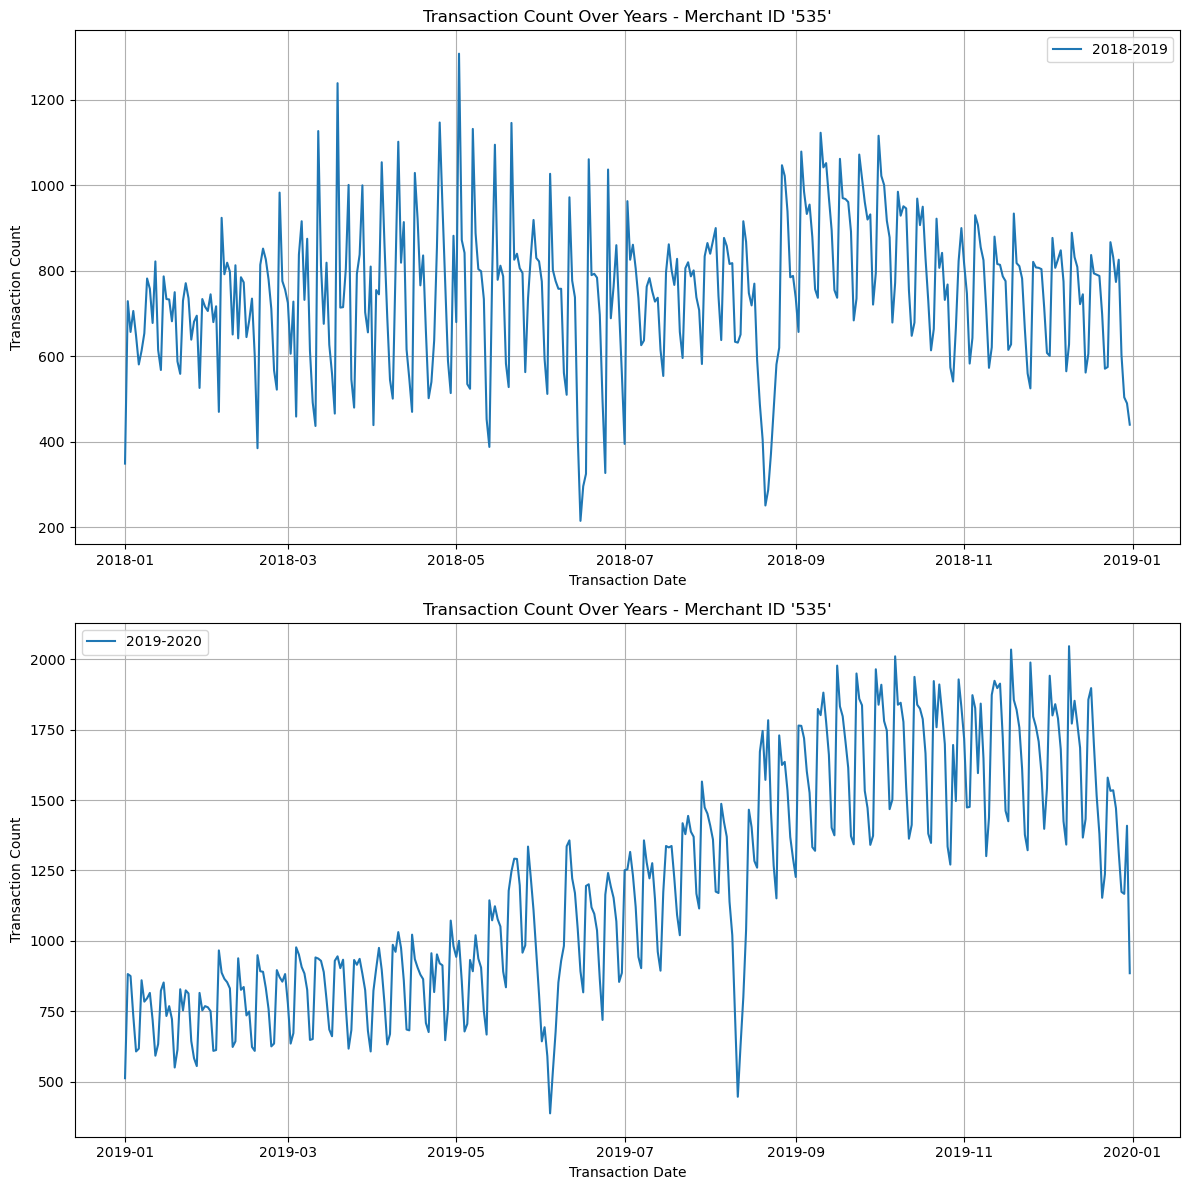

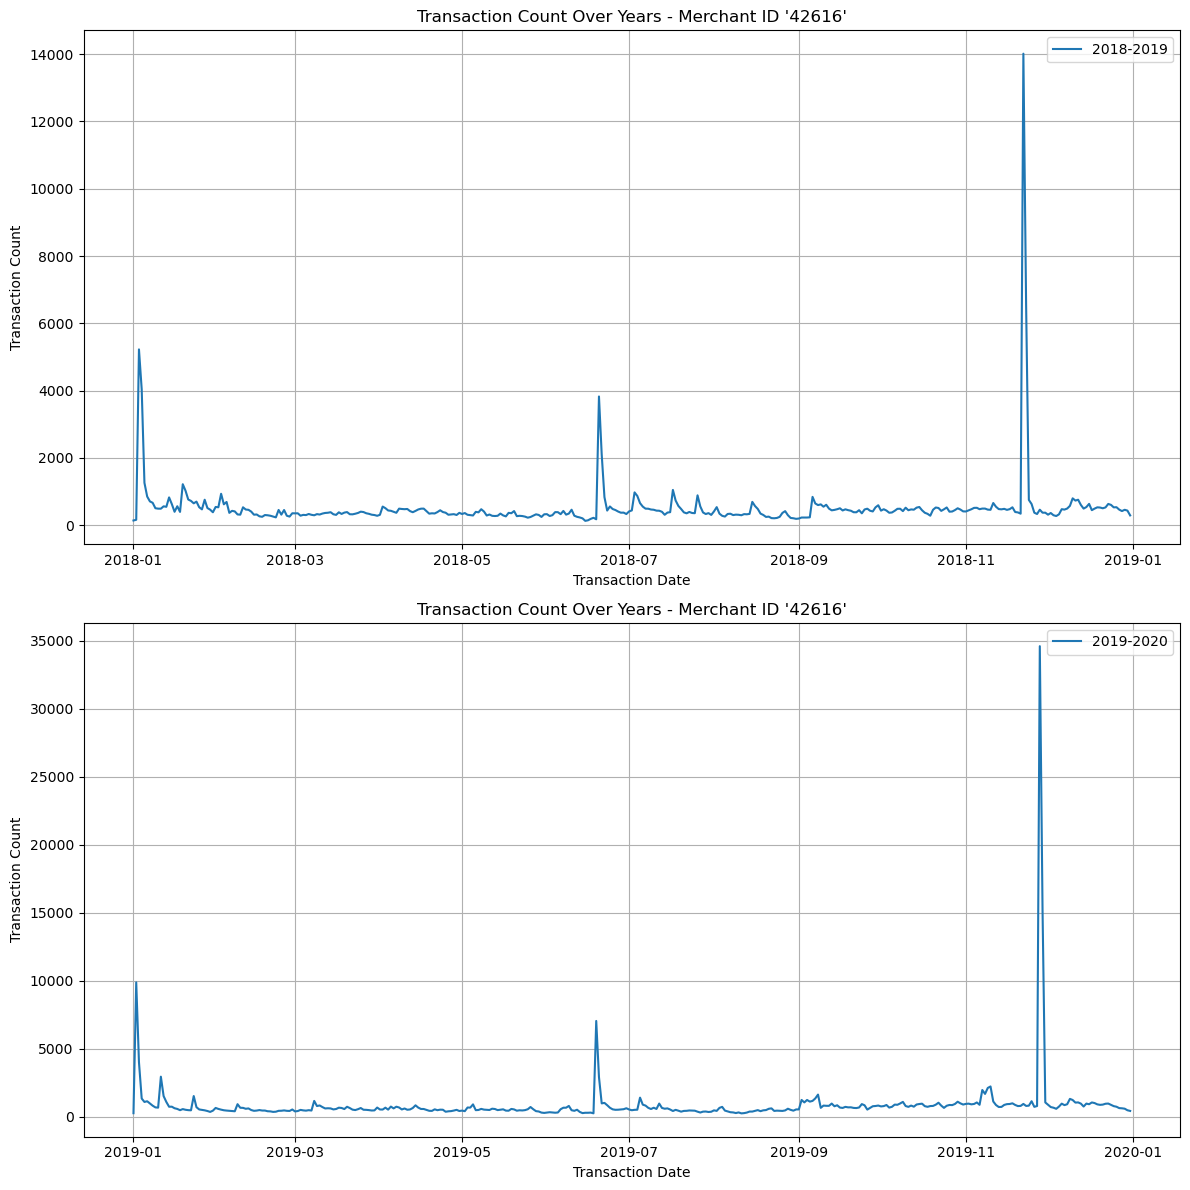

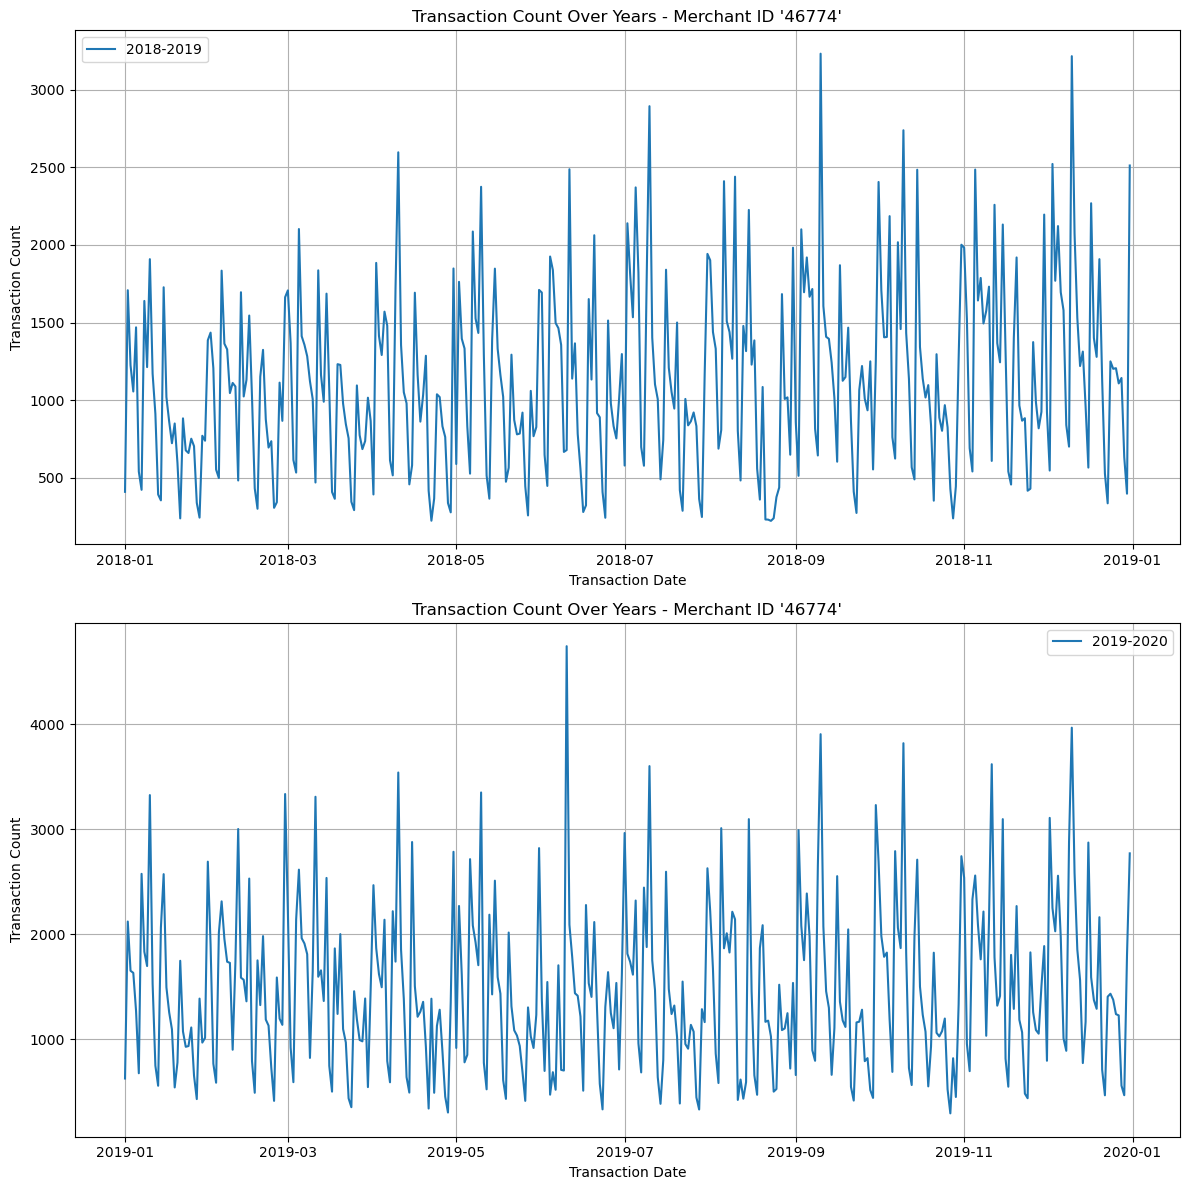

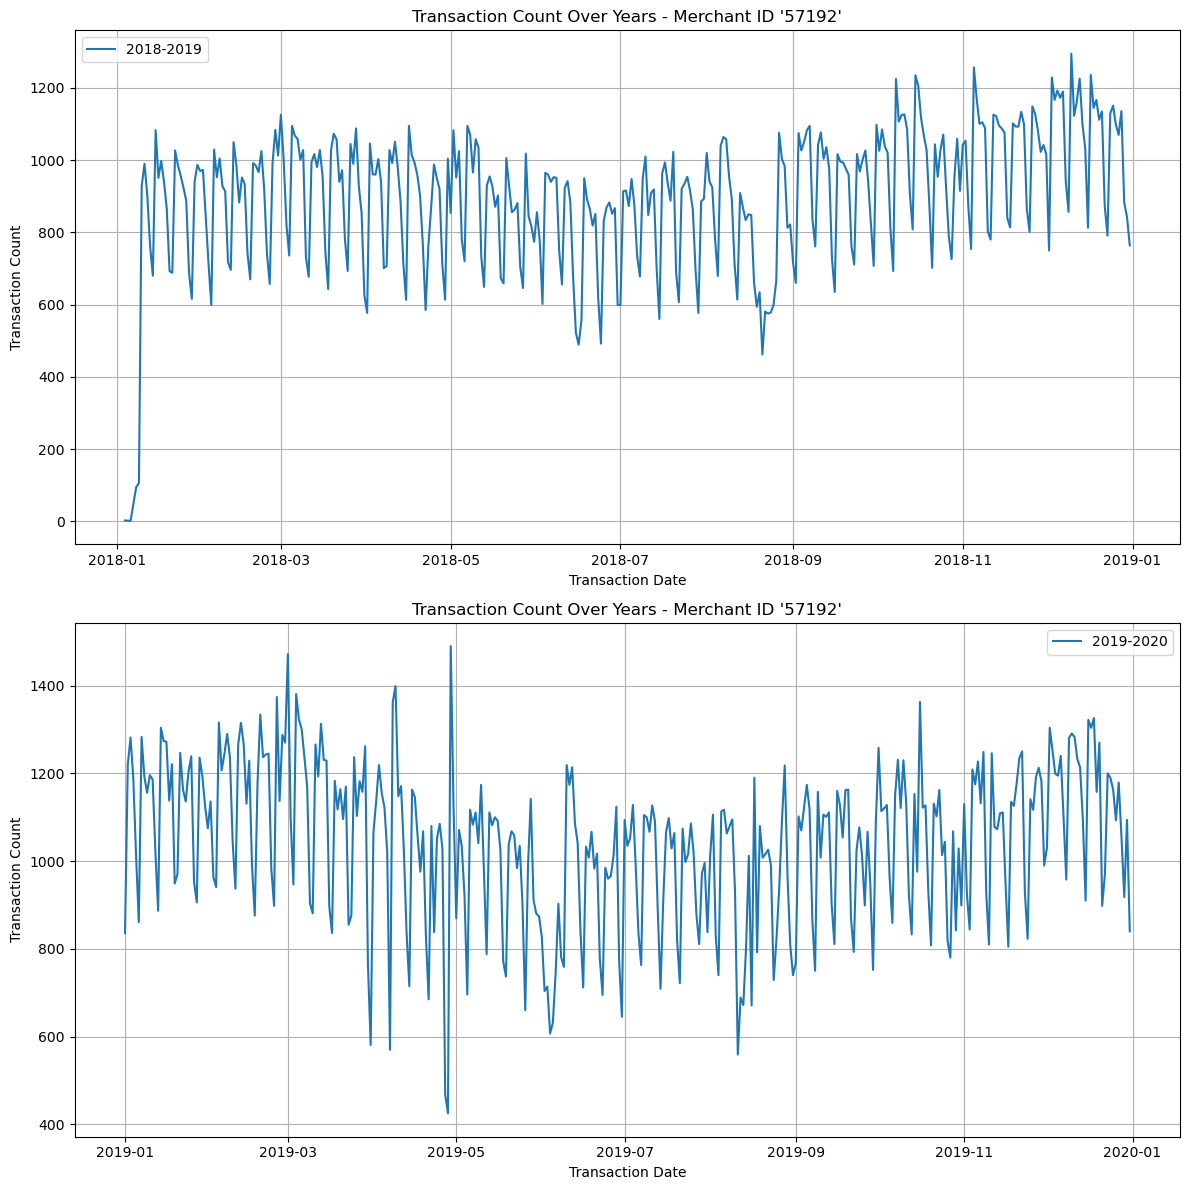

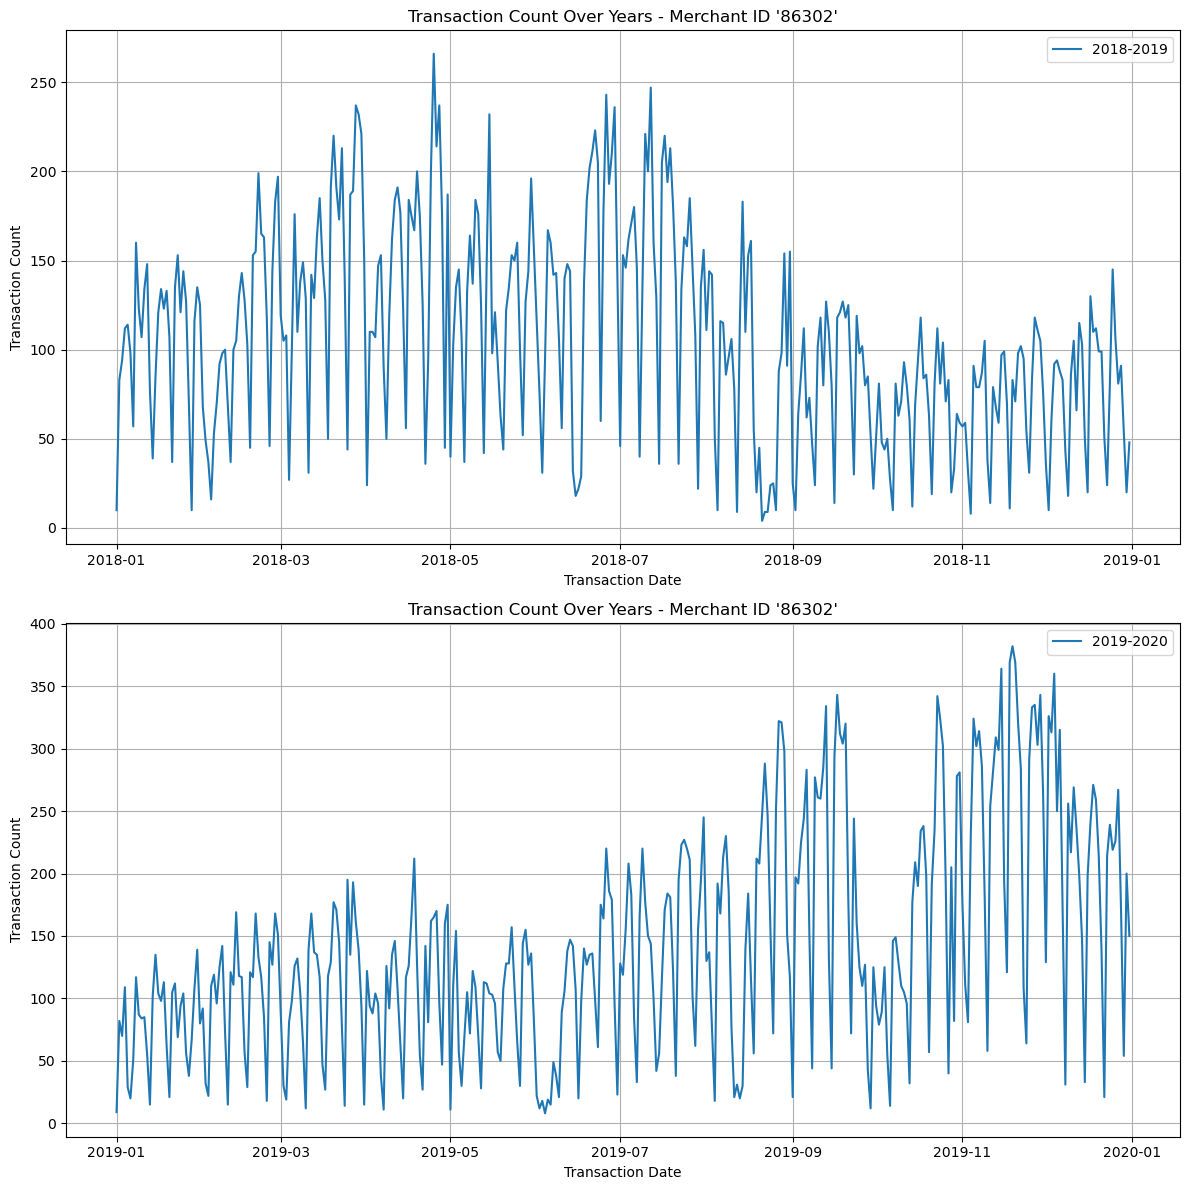

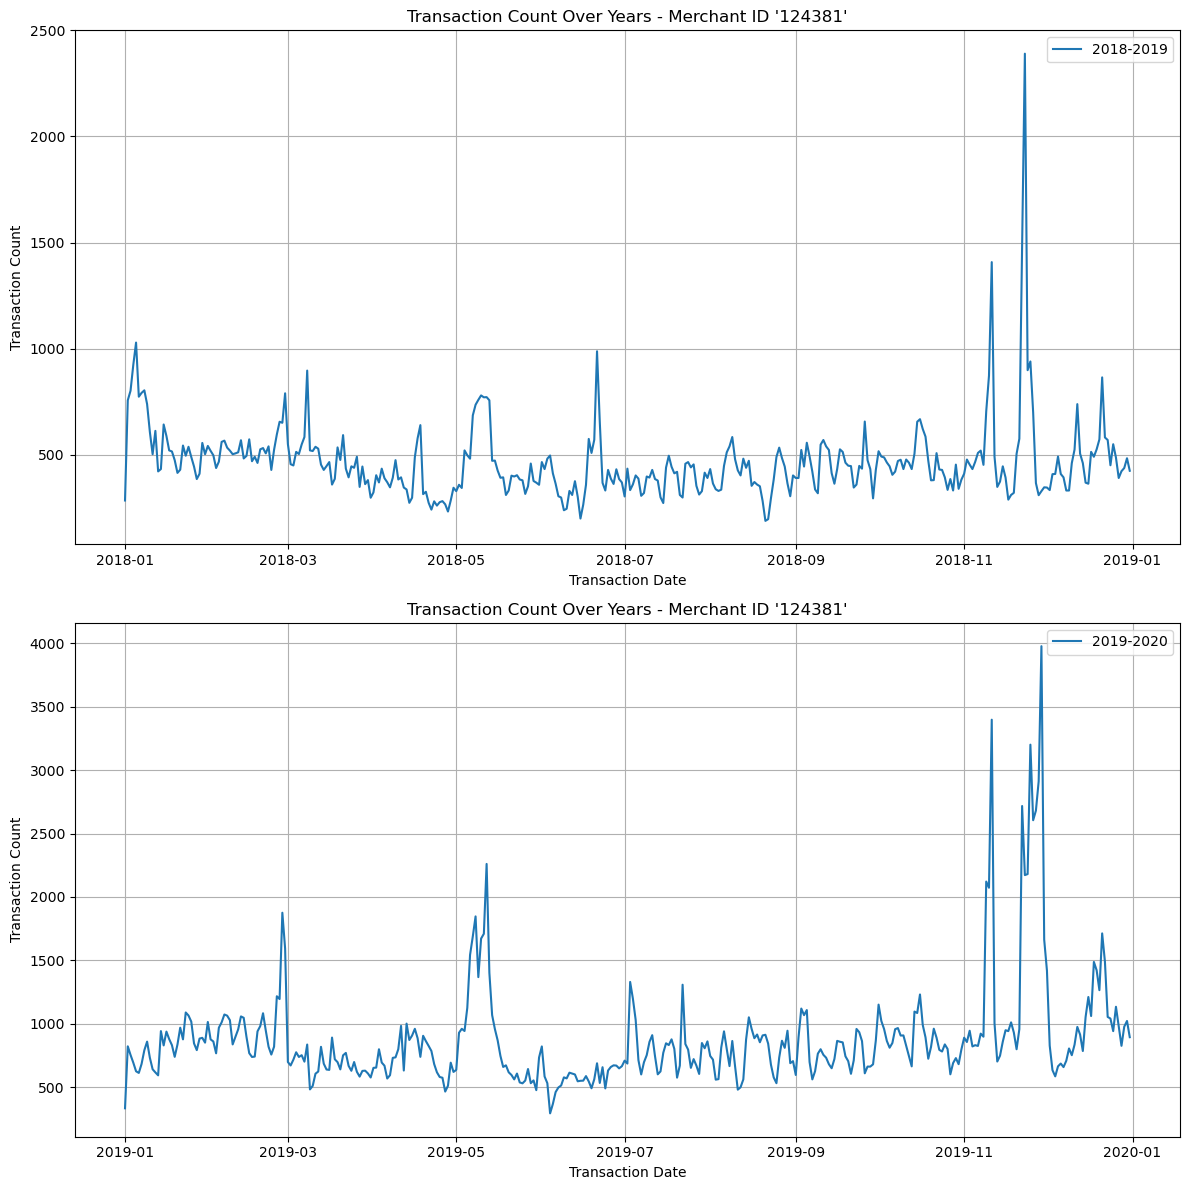

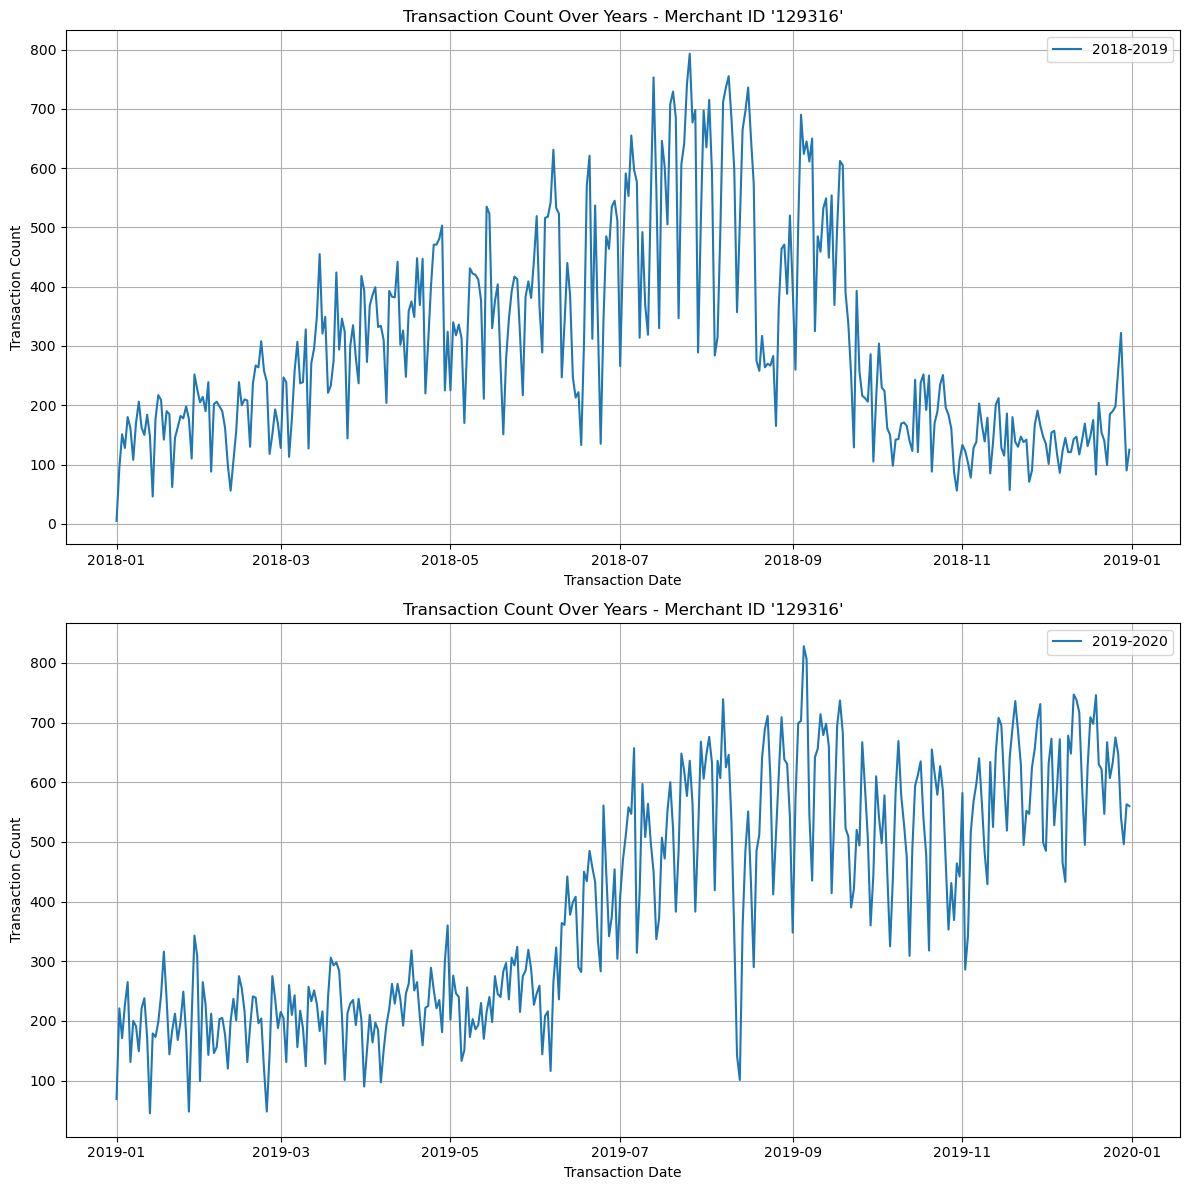

In [9]:
# Year ranges
year_ranges = [(2018, 2019), (2019, 2020)]

# Plotting graphs for each business and each year range
for merchant_id, group in df.groupby('merchant_id'):
    plt.figure(figsize=(12, 6 * len(year_ranges)))
    for i, year_range in enumerate(year_ranges, 1):
        start_year, end_year = year_range
        subset = group[
            (group['transaction_date'].dt.year >= start_year) &
            (group['transaction_date'].dt.year < end_year)
        ]

        plt.subplot(len(year_ranges), 1, i)
        plt.plot(subset['transaction_date'],
                 subset['Total_Transaction'], label=f'{start_year}-{end_year}')
        plt.title(
            f"Transaction Count Over Years - Merchant ID '{merchant_id}'")
        plt.xlabel('Transaction Date')
        plt.ylabel('Transaction Count')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

## Task 2: Apply Feature Engineering Techniques. Derive new features.
- **Lag/Shifted Features**
- **Rolling Mean Features**
- **Exponentially Weighted Mean Features**
- **Special days, exchange rates, etc.**

- **New Features**

In [10]:
# Create date features
def create_date_features(df, date_column):
    df['year'] = df[date_column].dt.year
    df['month'] = df[date_column].dt.month
    df['quarter'] = df[date_column].dt.quarter
    df['day_of_month'] = df[date_column].dt.day
    df['day_of_week'] = df[date_column].dt.dayofweek
    df['week_of_year'] = df[date_column].dt.isocalendar().week.astype(int)
    df['day_of_year'] = df[date_column].dt.dayofyear
    df['is_year_start'] = df[date_column].dt.is_year_start.astype(int)
    df['is_year_end'] = df[date_column].dt.is_year_end.astype(int)
    df['is_month_start'] = df[date_column].dt.is_month_start.astype(int)
    df['is_month_end'] = df[date_column].dt.is_month_end.astype(int)
    df['is_quarter_start'] = df[date_column].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df[date_column].dt.is_quarter_end.astype(int)
    df['is_wknd'] = df[date_column].dt.weekday // 4
    return df


df = create_date_features(df, 'transaction_date')

In [11]:
df.head()

,transaction_date,merchant_id,Total_Transaction,Total_Paid,year,month,quarter,day_of_month,day_of_week,week_of_year,day_of_year,is_year_start,is_year_end,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_wknd
0,2018-01-01,535,349,25883.226,2018,1,1,1,0,1,1,1,0,1,0,1,0,0
1,2018-01-01,42616,141,40918.860,2018,1,1,1,0,1,1,1,0,1,0,1,0,0
2,2018-01-01,46774,410,306902.700,2018,1,1,1,0,1,1,1,0,1,0,1,0,0
3,2018-01-01,86302,10,11.340,2018,1,1,1,0,1,1,1,0,1,0,1,0,0
4,2018-01-01,124381,285,111383.766,2018,1,1,1,0,1,1,1,0,1,0,1,0,0


In [12]:
# Grouping by Merchant, Year, Month, and Day of Month - Total Transaction Aggregation
df.groupby(['merchant_id', 'year', 'month', 'day_of_month']).agg({'Total_Transaction': ['mean', 'median', 'sum']})[:45]

Total_Transaction             
                                                 mean  median  sum
merchant_id year month day_of_month                               
535         2018 1     1                      349.000 349.000  349
                       2                      729.000 729.000  729
                       3                      657.000 657.000  657
                       4                      706.000 706.000  706
                       5                      648.000 648.000  648
                       6                      581.000 581.000  581
                       7                      613.000 613.000  613
                       8                      654.000 654.000  654
                       9                      782.000 782.000  782
                       10                     758.000 758.000  758
                       11                     678.000 678.000  678
                       12                     822.000 822.000  822
                       13                     615.000 615.000  615
                       14                     568.000 568.000  568
                       15                     787.000 787.000  787
                       16                     734.000 734.000  734
                       17                     733.000 733.000  733
                       18                     682.000 682.000  682
                       19                     750.000 750.000  750
                       20                     588.000 588.000  588
                       21                     559.000 559.000  559
                       22                     730.000 730.000  730
                       23                     771.000 771.000  771
                       24                     736.000 736.000  736
                       25                     639.000 639.000  639
                       26                     681.000 681.000  681
                       27                     695.000 695.000  695
                       28                     526.000 526.000  526
                       29                     734.000 734.000  734
                       30                     716.000 716.000  716
                       31                     706.000 706.000  706
                 2     1                      745.000 745.000  745
                       2                      680.000 680.000  680
                       3                      717.000 717.000  717
                       4                      470.000 470.000  470
                       5                      924.000 924.000  924
                       6                      792.000 792.000  792
                       7                      819.000 819.000  819
                       8                      798.000 798.000  798
                       9                      651.000 651.000  651
                       10                     813.000 813.000  813
                       11                     642.000 642.000  642
                       12                     785.000 785.000  785
                       13                     773.000 773.000  773
                       14                     645.000 645.000  645

In [13]:
# Grouping by Merchant, Year, and Month - Total Paid Aggregation
df.groupby(['merchant_id', 'year', 'month']).agg({'Total_Paid': ['mean', 'median', 'std', 'sum']})[:45]

Total_Paid                                  
                             mean     median        std         sum
merchant_id year month                                             
535         2018 1      67459.091  71088.660  12455.496 2091231.810
                 2      73590.038  73345.545  19428.542 2060521.056
                 3      76502.202  71045.640  28795.671 2371568.274
                 4      83485.292  83215.548  28798.308 2504558.754
                 5      91347.135  90838.422  31379.976 2831761.170
                 6      81104.599  84910.374  31874.749 2433137.958
                 7      88427.366  89439.408  13667.036 2741248.350
                 8      87895.807  91272.600  26163.244 2724770.016
                 9     104347.788 105952.887  22587.942 3130433.640
                 10    102807.190 106419.402  18794.994 3187022.904
                 11     98976.429 100661.193  16930.687 2969292.870
                 12     93468.325  98468.460  17433.766 2897518.086
            2019 1      97182.695 100325.430  16002.485 3012663.546
                 2     104055.879 106919.100  16904.617 2913564.600
                 3     117848.787 121570.200  17168.088 3653312.400
                 4     127527.600 130296.600  17034.671 3825828.000
                 5     145903.065 144327.600  26422.406 4522995.000
                 6     124449.300 131012.100  32509.873 3733479.000
                 7     155088.929 154940.400  18797.845 4807756.800
                 8     167207.981 171651.600  41004.795 5183447.400
                 9     192416.700 187962.300  28279.688 5772501.000
                 10    200022.213 208414.800  25660.219 6200688.600
                 11    191039.580 191918.700  24758.775 5731187.400
                 12    173849.400 181364.400  30439.044 5389331.400
            2020 1     178712.419 181672.200  21851.763 5540085.000
                 2     195832.055 196333.200  23438.003 5679129.600
                 3     162791.013 165427.200  50938.660 5046521.400
                 4      88371.120  90406.800  17771.937 2651133.600
                 5     130670.013 134643.600  27381.444 4050770.400
                 6     199431.420 197161.200  24671.698 5982942.600
                 7     214661.265 218934.000  39850.471 6654499.200
                 8     232056.000 242809.200  44823.841 7193736.000
                 9     247248.180 250673.400  28537.999 7417445.400
                 10    239072.168 239193.000  26669.460 7411237.200
                 11    218561.820 222322.500  23774.118 6556854.600
                 12    184753.394 194108.400  31295.303 5727355.200
42616       2018 1     168154.113 112042.386 188811.017 5212777.500
                 2      82723.762  78970.725  17322.862 2316265.344
                 3      85086.329  82773.486   9658.375 2637676.206
                 4     100915.798  96668.316  16235.391 3027473.946
                 5      78414.252  74222.712  13627.833 2430841.824
                 6     126737.321  87413.139 170979.846 3802119.642
                 7     102712.702  94726.710  36441.375 3184093.764
                 8      75603.144  76631.922  21955.404 2343697.452
                 9     130902.002 134526.258  34960.044 3927060.072

- **Lag/Shifted Features**

In [14]:
# Random noise function
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe), ))

In [15]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(['merchant_id'])['Total_Transaction'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe


df = lag_features(df, [91, 92, 93, 94, 95, 96, 97, 98, 99, 
                       100, 101, 105, 111, 112, 119, 121, 126, 
                       131, 133, 140, 147, 151, 154, 161, 168, 
                       171, 175, 181, 191, 211, 231, 241, 251, 
                       271, 291, 301, 311, 331, 351, 361, 371, 
                       391, 411, 431, 451, 471, 491, 511, 531, 
                       551, 571, 591, 611, 631, 651, 671, 691, 
                       711, 731, 751, 771, 791, 811, 831, 851, 
                       871, 891, 911, 931, 951, 971, 991])

- **Rolling Mean Features**

In [16]:
def roll_mean_features(dataframe, windows):
    new_columns = []

    for window in windows:
        col_name = f'sales_roll_mean_{str(window)}'
        new_columns.append(col_name)

        temp_df = dataframe.groupby('merchant_id')['Total_Transaction']. \
            transform(lambda x: x.shift(1).rolling(window=window, min_periods=7, win_type='triang').mean()) + random_noise(dataframe)

        dataframe = pd.concat([dataframe, temp_df.rename(col_name)], axis=1)

    return dataframe


df = roll_mean_features(df, [91, 92, 93, 94, 95, 96, 97, 98, 99, 
                            100, 101, 105, 111, 112, 119, 121, 126, 
                            131, 133, 140, 147, 151, 154, 161, 168, 
                            171, 175, 181, 191, 211, 231, 241, 251, 
                            271, 291, 301, 311, 331, 351, 361, 371, 
                            391, 411, 431, 451, 471, 491, 511, 531, 
                            551, 571, 591, 611, 631, 651, 671, 691, 
                            711, 731, 751, 771, 791, 811, 831, 851, 
                            871, 891, 911, 931, 951, 971, 991])

- **Exponentially Weighted Mean Features**

In [17]:
def ewm_features(dataframe, alphas, lags):
    new_columns = []

    for alpha in alphas:
        for lag in lags:
            col_name = f'sales_ewm_alpha_{str(alpha).replace(".", "")}_lag_{lag}'
            new_columns.append(col_name)

            temp_df = dataframe.groupby('merchant_id')['Total_Transaction'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
            dataframe = pd.concat([dataframe, temp_df.rename(col_name)], axis=1)

    return dataframe


alphas = [0.95, 0.9, 0.8, 0.7, 0.5]

lags = [91, 92, 93, 94, 95, 96, 97, 98, 99, 
        100, 101, 105, 111, 112, 119, 121, 126, 
        131, 133, 140, 147, 151, 154, 161, 168, 
        171, 175, 181, 191, 211, 231, 241, 251, 
        271, 291, 301, 311, 331, 351, 361, 371, 
        391, 411, 431, 451, 471, 491, 511, 531, 
        551, 571, 591, 611, 631, 651, 671, 691, 
        711, 731, 751, 771, 791, 811, 831, 851, 
        871, 891, 911, 931, 951, 971, 991]

df = ewm_features(df, alphas, lags)

- **Special days, exchange rates, etc.**

In [18]:
# Special days:
# - Valentine's Day
# - Black Friday
# - Summer Solstice
# - Cyber Monday
valentines_dates = ['2018-02-14', '2019-02-14', '2020-02-14']
black_friday_dates = ['2018-11-22', '2018-11-23', '2019-11-29', '2019-11-30', '2020-11-27']
summer_solstice_dates = ['2018-06-19', '2018-06-20', '2018-06-21', '2018-06-22', 
                         '2019-06-19', '2019-06-20', '2019-06-21', '2019-06-22',
                         '2020-06-20', '2020-06-21', '2020-06-22']
cyber_monday_dates = ['2018-11-26', '2019-12-02']

df = df.assign(
    is_valentines_day=df['transaction_date'].isin(valentines_dates).astype(int),
    is_black_friday=df['transaction_date'].isin(black_friday_dates).astype(int),
    is_summer_solstice=df['transaction_date'].isin(summer_solstice_dates).astype(int),
    is_cyber_monday=df['transaction_date'].isin(cyber_monday_dates).astype(int)
    )

In [19]:
df.head()

,transaction_date,merchant_id,Total_Transaction,Total_Paid,year,month,quarter,day_of_month,day_of_week,week_of_year,day_of_year,is_year_start,is_year_end,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_wknd,sales_lag_91,sales_lag_92,sales_lag_93,sales_lag_94,sales_lag_95,sales_lag_96,sales_lag_97,sales_lag_98,sales_lag_99,sales_lag_100,sales_lag_101,sales_lag_105,sales_lag_111,sales_lag_112,sales_lag_119,sales_lag_121,sales_lag_126,sales_lag_131,sales_lag_133,sales_lag_140,sales_lag_147,sales_lag_151,sales_lag_154,sales_lag_161,sales_lag_168,sales_lag_171,sales_lag_175,sales_lag_181,sales_lag_191,sales_lag_211,sales_lag_231,sales_lag_241,sales_lag_251,sales_lag_271,sales_lag_291,sales_lag_301,sales_lag_311,sales_lag_331,sales_lag_351,sales_lag_361,sales_lag_371,sales_lag_391,sales_lag_411,sales_lag_431,sales_lag_451,sales_lag_471,sales_lag_491,sales_lag_511,sales_lag_531,sales_lag_551,sales_lag_571,sales_lag_591,sales_lag_611,sales_lag_631,sales_lag_651,sales_lag_671,sales_lag_691,sales_lag_711,sales_lag_731,sales_lag_751,sales_lag_771,sales_lag_791,sales_lag_811,sales_lag_831,sales_lag_851,sales_lag_871,sales_lag_891,sales_lag_911,sales_lag_931,sales_lag_951,sales_lag_971,sales_lag_991,sales_roll_mean_91,sales_roll_mean_92,sales_roll_mean_93,sales_roll_mean_94,sales_roll_mean_95,sales_roll_mean_96,sales_roll_mean_97,sales_roll_mean_98,sales_roll_mean_99,sales_roll_mean_100,sales_roll_mean_101,sales_roll_mean_105,sales_roll_mean_111,sales_roll_mean_112,sales_roll_mean_119,sales_roll_mean_121,sales_roll_mean_126,sales_roll_mean_131,sales_roll_mean_133,sales_roll_mean_140,sales_roll_mean_147,sales_roll_mean_151,sales_roll_mean_154,sales_roll_mean_161,sales_roll_mean_168,sales_roll_mean_171,sales_roll_mean_175,sales_roll_mean_181,sales_roll_mean_191,sales_roll_mean_211,sales_roll_mean_231,sales_roll_mean_241,sales_roll_mean_251,sales_roll_mean_271,sales_roll_mean_291,sales_roll_mean_301,sales_roll_mean_311,sales_roll_mean_331,sales_roll_mean_351,sales_roll_mean_361,sales_roll_mean_371,sales_roll_mean_391,sales_roll_mean_411,sales_roll_mean_431,sales_roll_mean_451,sales_roll_mean_471,sales_roll_mean_491,sales_roll_mean_511,sales_roll_mean_531,sales_roll_mean_551,sales_roll_mean_571,sales_roll_mean_591,sales_roll_mean_611,sales_roll_mean_631,sales_roll_mean_651,sales_roll_mean_671,sales_roll_mean_691,sales_roll_mean_711,sales_roll_mean_731,sales_roll_mean_751,sales_roll_mean_771,sales_roll_mean_791,sales_roll_mean_811,sales_roll_mean_831,sales_roll_mean_851,sales_roll_mean_871,sales_roll_mean_891,sales_roll_mean_911,sales_roll_mean_931,sales_roll_mean_951,sales_roll_mean_971,sales_roll_mean_991,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_92,sales_ewm_alpha_095_lag_93,sales_ewm_alpha_095_lag_94,sales_ewm_alpha_095_lag_95,sales_ewm_alpha_095_lag_96,sales_ewm_alpha_095_lag_97,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_99,sales_ewm_alpha_095_lag_100,sales_ewm_alpha_095_lag_101,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_111,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_119,sales_ewm_alpha_095_lag_121,sales_ewm_alpha_095_lag_126,sales_ewm_alpha_095_lag_131,sales_ewm_alpha_095_lag_133,sales_ewm_alpha_095_lag_140,sales_ewm_alpha_095_lag_147,sales_ewm_alpha_095_lag_151,sales_ewm_alpha_095_lag_154,sales_ewm_alpha_095_lag_161,sales_ewm_alpha_095_lag_168,sales_ewm_alpha_095_lag_171,sales_ewm_alpha_095_lag_175,sales_ewm_alpha_095_lag_181,sales_ewm_alpha_095_lag_191,sales_ewm_alpha_095_lag_211,sales_ewm_alpha_095_lag_231,sales_ewm_alpha_095_lag_241,sales_ewm_alpha_095_lag_251,sales_ewm_alpha_095_lag_271,sales_ewm_alpha_095_lag_291,sales_ewm_alpha_095_lag_301,sales_ewm_alpha_095_lag_311,sales_ewm_alpha_095_lag_331,sales_ewm_alpha_095_lag_351,sales_ewm_alpha_095_lag_361,sales_ewm_alpha_095_lag_371,sales_ewm_alpha_095_lag_391,sales_ewm_alpha_095_lag_411,sales_ewm_alpha_095_lag_431,sales_ewm_alpha_095_lag_451,sales_ewm_alpha_095_lag_471,sales_ewm_alpha_095_lag_491,sales_ewm_alpha_095_lag_511,sales_ewm_alp

## Task 3: Preparation for Modeling and Modeling.

In [20]:
# Count unique values for each column in a DataFrame and sort them based on counts.
def count_and_sort_unique_values(df, threshold=10, ascending=True):
    # Count unique values for each column
    unique_counts = df.nunique()

    # Filter columns with counts less than the threshold
    selected_columns = unique_counts[unique_counts <= threshold].index

    # Sort the counts based on the specified order
    unique_counts_selected_columns = unique_counts[selected_columns].sort_values(ascending=ascending)

    return unique_counts_selected_columns


# Sort
result = count_and_sort_unique_values(df, threshold=12, ascending=False)
print('Count of Unique Values for Selected Thresholds (Sorted):')
print(result)


Count of Unique Values for Selected Thresholds (Sorted):
month                 12
merchant_id            7
day_of_week            7
quarter                4
year                   3
is_year_start          2
is_year_end            2
is_month_start         2
is_month_end           2
is_quarter_start       2
is_quarter_end         2
is_wknd                2
is_valentines_day      2
is_black_friday        2
is_summer_solstice     2
is_cyber_monday        2
dtype: int64


### Step 1: Perform one-hot encoding.

In [21]:
df = pd.get_dummies(df, columns=['merchant_id', 'day_of_week', 'month'])

In [22]:
df.head()

,transaction_date,Total_Transaction,Total_Paid,year,quarter,day_of_month,week_of_year,day_of_year,is_year_start,is_year_end,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_wknd,sales_lag_91,sales_lag_92,sales_lag_93,sales_lag_94,sales_lag_95,sales_lag_96,sales_lag_97,sales_lag_98,sales_lag_99,sales_lag_100,sales_lag_101,sales_lag_105,sales_lag_111,sales_lag_112,sales_lag_119,sales_lag_121,sales_lag_126,sales_lag_131,sales_lag_133,sales_lag_140,sales_lag_147,sales_lag_151,sales_lag_154,sales_lag_161,sales_lag_168,sales_lag_171,sales_lag_175,sales_lag_181,sales_lag_191,sales_lag_211,sales_lag_231,sales_lag_241,sales_lag_251,sales_lag_271,sales_lag_291,sales_lag_301,sales_lag_311,sales_lag_331,sales_lag_351,sales_lag_361,sales_lag_371,sales_lag_391,sales_lag_411,sales_lag_431,sales_lag_451,sales_lag_471,sales_lag_491,sales_lag_511,sales_lag_531,sales_lag_551,sales_lag_571,sales_lag_591,sales_lag_611,sales_lag_631,sales_lag_651,sales_lag_671,sales_lag_691,sales_lag_711,sales_lag_731,sales_lag_751,sales_lag_771,sales_lag_791,sales_lag_811,sales_lag_831,sales_lag_851,sales_lag_871,sales_lag_891,sales_lag_911,sales_lag_931,sales_lag_951,sales_lag_971,sales_lag_991,sales_roll_mean_91,sales_roll_mean_92,sales_roll_mean_93,sales_roll_mean_94,sales_roll_mean_95,sales_roll_mean_96,sales_roll_mean_97,sales_roll_mean_98,sales_roll_mean_99,sales_roll_mean_100,sales_roll_mean_101,sales_roll_mean_105,sales_roll_mean_111,sales_roll_mean_112,sales_roll_mean_119,sales_roll_mean_121,sales_roll_mean_126,sales_roll_mean_131,sales_roll_mean_133,sales_roll_mean_140,sales_roll_mean_147,sales_roll_mean_151,sales_roll_mean_154,sales_roll_mean_161,sales_roll_mean_168,sales_roll_mean_171,sales_roll_mean_175,sales_roll_mean_181,sales_roll_mean_191,sales_roll_mean_211,sales_roll_mean_231,sales_roll_mean_241,sales_roll_mean_251,sales_roll_mean_271,sales_roll_mean_291,sales_roll_mean_301,sales_roll_mean_311,sales_roll_mean_331,sales_roll_mean_351,sales_roll_mean_361,sales_roll_mean_371,sales_roll_mean_391,sales_roll_mean_411,sales_roll_mean_431,sales_roll_mean_451,sales_roll_mean_471,sales_roll_mean_491,sales_roll_mean_511,sales_roll_mean_531,sales_roll_mean_551,sales_roll_mean_571,sales_roll_mean_591,sales_roll_mean_611,sales_roll_mean_631,sales_roll_mean_651,sales_roll_mean_671,sales_roll_mean_691,sales_roll_mean_711,sales_roll_mean_731,sales_roll_mean_751,sales_roll_mean_771,sales_roll_mean_791,sales_roll_mean_811,sales_roll_mean_831,sales_roll_mean_851,sales_roll_mean_871,sales_roll_mean_891,sales_roll_mean_911,sales_roll_mean_931,sales_roll_mean_951,sales_roll_mean_971,sales_roll_mean_991,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_92,sales_ewm_alpha_095_lag_93,sales_ewm_alpha_095_lag_94,sales_ewm_alpha_095_lag_95,sales_ewm_alpha_095_lag_96,sales_ewm_alpha_095_lag_97,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_99,sales_ewm_alpha_095_lag_100,sales_ewm_alpha_095_lag_101,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_111,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_119,sales_ewm_alpha_095_lag_121,sales_ewm_alpha_095_lag_126,sales_ewm_alpha_095_lag_131,sales_ewm_alpha_095_lag_133,sales_ewm_alpha_095_lag_140,sales_ewm_alpha_095_lag_147,sales_ewm_alpha_095_lag_151,sales_ewm_alpha_095_lag_154,sales_ewm_alpha_095_lag_161,sales_ewm_alpha_095_lag_168,sales_ewm_alpha_095_lag_171,sales_ewm_alpha_095_lag_175,sales_ewm_alpha_095_lag_181,sales_ewm_alpha_095_lag_191,sales_ewm_alpha_095_lag_211,sales_ewm_alpha_095_lag_231,sales_ewm_alpha_095_lag_241,sales_ewm_alpha_095_lag_251,sales_ewm_alpha_095_lag_271,sales_ewm_alpha_095_lag_291,sales_ewm_alpha_095_lag_301,sales_ewm_alpha_095_lag_311,sales_ewm_alpha_095_lag_331,sales_ewm_alpha_095_lag_351,sales_ewm_alpha_095_lag_361,sales_ewm_alpha_095_lag_371,sales_ewm_alpha_095_lag_391,sales_ewm_alpha_095_lag_411,sales_ewm_alpha_095_lag_431,sales_ewm_alpha_095_lag_451,sales_ewm_alpha_095_lag_471,sales_ewm_alpha_095_lag_491,sales_ewm_alpha_095_lag_511,sales_ewm_alpha_095_lag_531,sales_ewm_alpha

- **Target variable before log transformation**

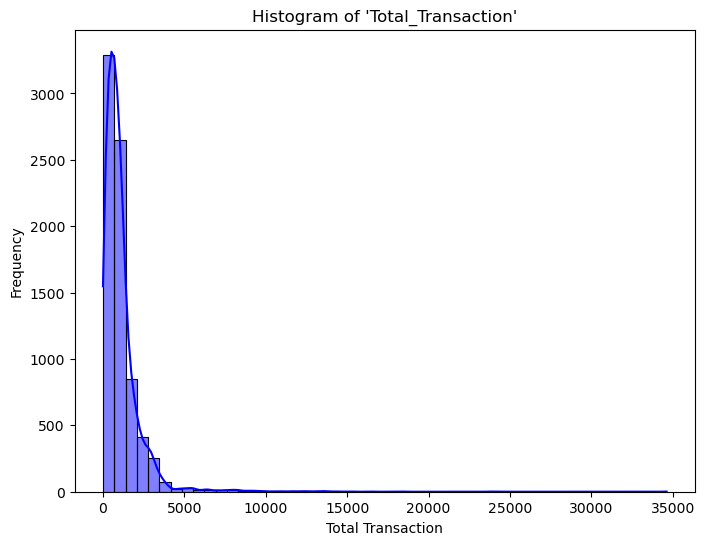

Skewness before log transformation: 6.811


In [23]:
# Histogram of 'Total_Transaction'
plt.figure(figsize=(8, 6))
sns.histplot(df['Total_Transaction'], bins=50, kde=True, color='blue')
plt.title("Histogram of 'Total_Transaction'")
plt.xlabel('Total Transaction')
plt.ylabel('Frequency')
plt.show()

# Skewness of 'Total_Transaction'
skewness_before = df['Total_Transaction'].skew()
print(f'Skewness before log transformation: {skewness_before:.3f}')

- **Target variable after log transformation**

In [24]:
# Target variable log transformation
df['Total_Transaction'] = np.log1p(df['Total_Transaction'])

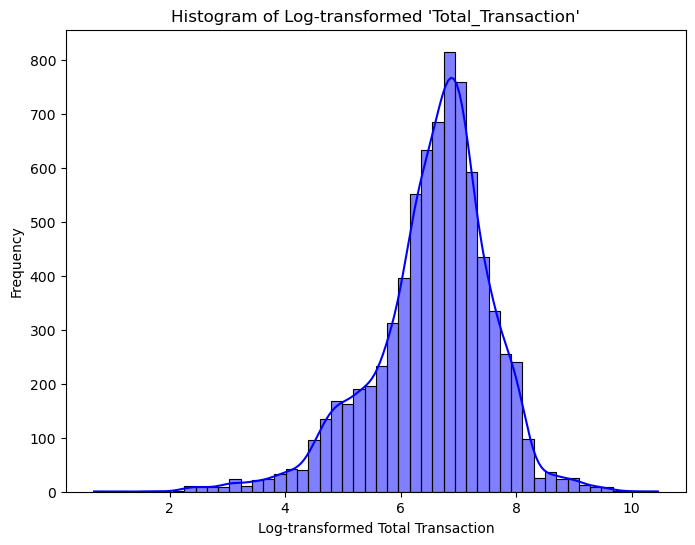

Skewness after log transformation: -0.784


In [25]:
# Histogram of the log-transformed 'Total_Transaction'
plt.figure(figsize=(8, 6))
sns.histplot(df['Total_Transaction'], bins=50, kde=True, color='blue')
plt.title("Histogram of Log-transformed 'Total_Transaction'")
plt.xlabel('Log-transformed Total Transaction')
plt.ylabel('Frequency')
plt.show()

# Skewness of the log-transformed 'Total_Transaction'
skewness_after = df['Total_Transaction'].skew()
print(f'Skewness after log transformation: {skewness_after:.3f}')

### Step 2: Define Custom Cost Functions.

In [26]:
# SMAPE (Symmetric Mean Absolute Percentage Error) Calculation Function
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

In [27]:
# LightGBM Custom Evaluation Function for SMAPE
def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

### Step 3: Split the data set into train and validation sets.

In [28]:
# The training set: Data up to September 30, 2020
train = df.loc[(df['transaction_date'] < '2020-10-01'), :]

# The validation set: Data from October 1, 2020, onward to predict the last 3 months of the year 2020
val = df.loc[(df['transaction_date'] >= '2020-10-01'), :]

In [29]:
# Excluding columns: 'transaction_date', 'merchant_id ', 'Total_Transaction', 'Total_Paid', 'year'
cols = [col for col in train.columns if col not in ['transaction_date', 'merchant_id ', 
                                                    'Total_Transaction', 'Total_Paid', 'year']]

In [30]:
# Splitting the dataset into target variables (Y) and feature variables (X) for both training and validation sets
Y_train = train['Total_Transaction']
X_train = train[cols]

Y_val = val['Total_Transaction']
X_val = val[cols]

In [31]:
# Displaying the shapes of Y_train, X_train, Y_val, and X_val
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((7023,), (7023, 545), (644,), (644, 545))

## Task 4: Create a LightGBM Model and observe the error value with SMAPE.

In [32]:
# LightGBM Parameters for Model Training
lgb_params = {'num_leaves': 10, 
              'learning_rate': 0.02, 
              'feature_fraction': 0.8, 
              'max_depth': 5, 
              'verbose': 0, 
              'nthread': -1}

In [33]:
# LightGBM Datasets for Training and Validation
lgb_train = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgb_val = lgb.Dataset(data=X_val, label=Y_val, reference=lgb_train, feature_name=cols)

In [34]:
# LightGBM Model Training
callbacks = [lgb.early_stopping(stopping_rounds=100, 
                                first_metric_only=False), 
                                lgb.log_evaluation(period=100)]

model = lgb.train(params=lgb_params, 
                  train_set=lgb_train, 
                  valid_sets=[lgb_train, lgb_val], 
                  num_boost_round=10000, 
                  callbacks=callbacks, 
                  feval=lgbm_smape)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022653 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.181282	training's SMAPE: 27.9168	valid_1's l2: 0.181166	valid_1's SMAPE: 28.2218
[200]	training's l2: 0.124645	training's SMAPE: 22.6176	valid_1's l2: 0.134953	valid_1's SMAPE: 22.622
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	training's l2: 0.106687	training's SMAPE: 20.8088	valid_1's l2: 0.129019	valid_1's SMAPE: 22.3987
[LightGBM] [

In [35]:
# Predicting Validation Set
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

In [36]:
# Calculate SMAPE (Symmetric Mean Absolute Percentage Error) for the validation set predictions (reverting from log transformation)
smape(np.expm1(y_pred_val), np.expm1(Y_val))

22.176409133507665

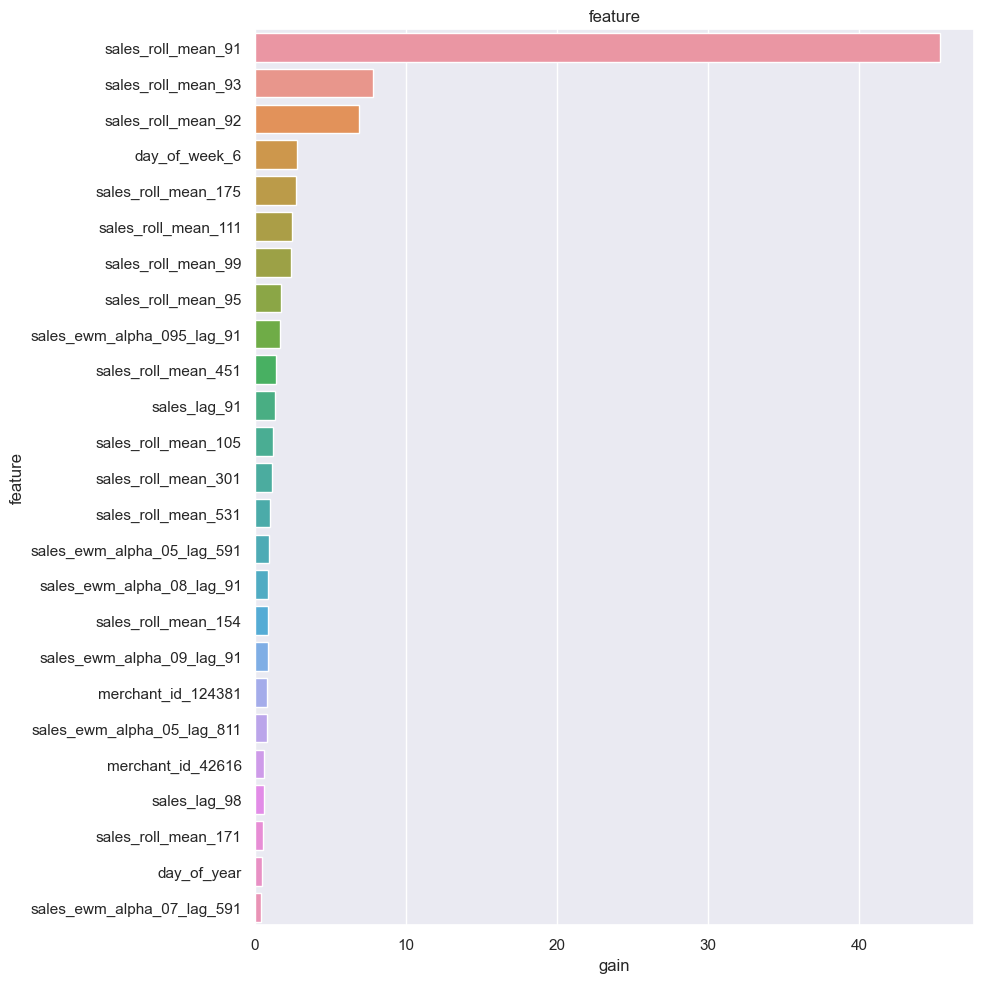

First 20 Features
-----------------
                        feature  split   gain
83           sales_roll_mean_91    182 45.319
85           sales_roll_mean_93     20  7.828
84           sales_roll_mean_92     42  6.893
532               day_of_week_6    132  2.790
109         sales_roll_mean_175     13  2.716
95          sales_roll_mean_111     29  2.464
91           sales_roll_mean_99      9  2.415
87           sales_roll_mean_95     21  1.721
155  sales_ewm_alpha_095_lag_91     34  1.656
127         sales_roll_mean_451     10  1.371
11                 sales_lag_91     36  1.351
94          sales_roll_mean_105     11  1.222
118         sales_roll_mean_301      7  1.117
131         sales_roll_mean_531     21  0.964
494  sales_ewm_alpha_05_lag_591     61  0.935
299   sales_ewm_alpha_08_lag_91     14  0.875
105         sales_roll_mean_154      7  0.872
227   sales_ewm_alpha_09_lag_91     23  0.864
524          merchant_id_124381     42  0.807
505  sales_ewm_alpha_05_lag_811     54  0.78

In [37]:
# Feature Importances
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    
    heading = f'First {num} Features'
    print(heading)
    print('-' * len(heading))
    print(feat_imp.head(num))


# Plot feature importances using custom function
plot_lgb_importances(model, num=20, plot=True)

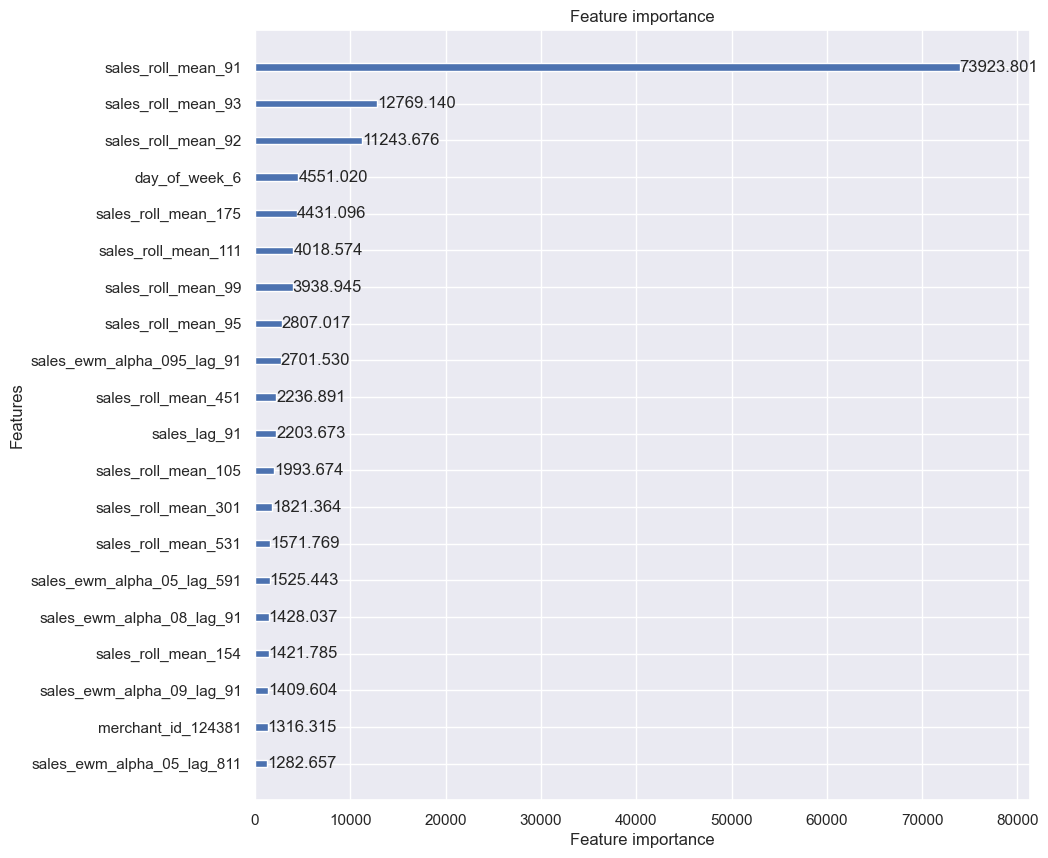

In [38]:
# Plot feature importances using LightGBM's built-in function
lgb.plot_importance(model, max_num_features=20, figsize=(10, 10), importance_type='gain')
plt.show()